<a href="https://colab.research.google.com/github/shrianshjena/LSTM_Based_Stock_Pattern_Prediction_Enhanced_With_The_Attention_Mechanism/blob/main/Stock_Pattern_Prediction_using_LSTM_with_the_Attention_Mechanism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LSTM-Based Stock Pattern Prediction Enhanced With The Attention Mechanism**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import warnings
warnings.filterwarnings('ignore')

### **Fetching Data**

In [ ]:
# Fetching AAPL data from Yahoo Finance
aapl_data = yf.download('AAPL', start='2020-01-01', end='2024-01-01')

print(aapl_data.head())

[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2020-01-02  74.059998  75.150002  73.797501  75.087502  72.960472  135480400
2020-01-03  74.287498  75.144997  74.125000  74.357498  72.251144  146322800
2020-01-06  73.447502  74.989998  73.187500  74.949997  72.826851  118387200
2020-01-07  74.959999  75.224998  74.370003  74.597504  72.484344  108872000
2020-01-08  74.290001  76.110001  74.290001  75.797501  73.650330  132079200


### **Data Inspection and Cleaning**

In [ ]:
# Check for missing values
missing_values = aapl_data.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Fill missing values using forward fill
aapl_data.fillna(method='ffill', inplace=True)

missing_values_after_fill = aapl_data.isnull().sum()
print("Missing values after filling:\n", missing_values_after_fill)

Missing values in each column:
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Missing values after filling:
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


### **Data Scaling**

In [ ]:
# Initialize the MinMaxScaler with feature range between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the 'Close' column of the AAPL stock data
aapl_data_scaled = scaler.fit_transform(aapl_data['Close'].values.reshape(-1, 1))

print("First few rows of scaled 'Close' data:\n", aapl_data_scaled[:5])

First few rows of scaled 'Close' data:
 [[0.13375114]
 [0.1286109 ]
 [0.13278292]
 [0.13030088]
 [0.13875052]]


### **Creating Sequences for LSTM**

In [ ]:
# Initialize empty lists to hold input sequences (X) and corresponding outputs (y)
X = []
y = []

# Create sequences of 60 time steps from the scaled closing prices
for i in range(60, len(aapl_data_scaled)):
    # Append the sequence of 60 previous values to X
    X.append(aapl_data_scaled[i-60:i, 0])
    # Append the next value to y
    y.append(aapl_data_scaled[i, 0])

### **Splitting the Data into Training and Testing Sets**

In [ ]:
# Defining the size of the training set (80% of the data)
train_size = int(len(X) * 0.8)
# The size of the test set is the remaining 20%
test_size = len(X) - train_size

# Splitting the data into training and testing sets
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training set size: {len(X_train)}, Test set size: {len(X_test)}")

Training set size: 756, Test set size: 190


### **Reshaping Data for LSTM Input**

In [ ]:
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the data to be suitable for LSTM input
# LSTM expects input in the form (number of samples, number of time steps, number of features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(f"Reshaped X_train shape: {X_train.shape}")

Reshaped X_train shape: (756, 60, 1)


## **Constructing the LSTM Model with Attention Mechanism**

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, AdditiveAttention, Permute, Reshape, Multiply, BatchNormalization, Flatten

### **Adding LSTM Layers and the Attention Mechanism**

In [ ]:
model = Sequential()

# Adding the first LSTM layer with return_sequences=True to stack more layers later
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
# Adding the second LSTM layer with return_sequences=True for attention mechanism
model.add(LSTM(units=50, return_sequences=True))

# Adding self-attention mechanism
# Initializing attention layer
attention = AdditiveAttention(name='attention_weight')

# Permute the dimensions of LSTM output for compatibility with attention layer
model.add(Permute((2, 1)))

# Reshape the output to match the required input shape for the attention layer
model.add(Reshape((-1, X_train.shape[1])))

# Applying the attention mechanism
attention_result = attention([model.output, model.output])

# Multiply the LSTM output with the attention result to emphasize important features
multiply_layer = Multiply()([model.output, attention_result])

# Return to original shape after attention mechanism
model.add(Permute((2, 1)))
model.add(Reshape((-1, 50)))

# Flatten the output before the final Dense layer
model.add(Flatten())

# Add the final Dense layer with one output unit
model.add(Dense(1))

# model.compile(optimizer='adam', loss='mean_squared_error')

# history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2)

### **Model Optimization**

In [ ]:
# Adding Dropout and Batch Normalization layers for regularization
model.add(Dropout(0.2))  # Dropout to prevent overfitting
model.add(BatchNormalization())  # Batch normalization to stabilize and accelerate training

### **Compiling the Model**

In [ ]:
# Compile the model with Mean Squared Error loss and Adam optimizer
model.compile(optimizer='adam', loss='mean_squared_error')

### **Model Summary**

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 permute (Permute)           (None, 50, 60)            0         
                                                                 
 reshape (Reshape)           (None, 50, 60)            0         
                                                                 
 permute_1 (Permute)         (None, 60, 50)            0         
                                                                 
 reshape_1 (Reshape)         (None, 60, 50)            0         
                                                                 
 flatten (Flatten)           (None, 3000)              0

### **Training the Model**

In [ ]:
# Train the model on the training data with a validation split of 20%
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2)

Epoch 1/100
25/25 [==============================] - 12s 99ms/step - loss: 0.7285 - val_loss: 0.3526
Epoch 2/100
25/25 [==============================] - 1s 59ms/step - loss: 0.3054 - val_loss: 0.3509
Epoch 3/100
25/25 [==============================] - 1s 59ms/step - loss: 0.2538 - val_loss: 0.3387
Epoch 4/100
25/25 [==============================] - 1s 59ms/step - loss: 0.2273 - val_loss: 0.3086
Epoch 5/100
25/25 [==============================] - 2s 81ms/step - loss: 0.2035 - val_loss: 0.2795
Epoch 6/100
25/25 [==============================] - 3s 101ms/step - loss: 0.1846 - val_loss: 0.2571
Epoch 7/100
25/25 [==============================] - 1s 57ms/step - loss: 0.1686 - val_loss: 0.2261
Epoch 8/100
25/25 [==============================] - 1s 58ms/step - loss: 0.1501 - val_loss: 0.2020
Epoch 9/100
25/25 [==============================] - 1s 58ms/step - loss: 0.1377 - val_loss: 0.2018
Epoch 10/100
25/25 [==============================] - 1s 60ms/step - loss: 0.1250 - val_loss: 0.18

### **Adding Early Stopping Callback**

In [ ]:
from keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
# Stop training when the validation loss does not improve for 10 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=[early_stopping])

print(f"Training stopped after {len(history.epoch)} epochs")

Epoch 1/100
25/25 [==============================] - 2s 61ms/step - loss: 0.0099 - val_loss: 0.0013
Epoch 2/100
25/25 [==============================] - 1s 59ms/step - loss: 0.0115 - val_loss: 0.0014
Epoch 3/100
25/25 [==============================] - 1s 59ms/step - loss: 0.0103 - val_loss: 0.0039
Epoch 4/100
25/25 [==============================] - 2s 91ms/step - loss: 0.0114 - val_loss: 0.0048
Epoch 5/100
25/25 [==============================] - 2s 75ms/step - loss: 0.0110 - val_loss: 0.0052
Epoch 6/100
25/25 [==============================] - 1s 59ms/step - loss: 0.0099 - val_loss: 0.0022
Epoch 7/100
25/25 [==============================] - 1s 58ms/step - loss: 0.0103 - val_loss: 8.7064e-04
Epoch 8/100
25/25 [==============================] - 1s 59ms/step - loss: 0.0083 - val_loss: 0.0020
Epoch 9/100
25/25 [==============================] - 1s 58ms/step - loss: 0.0110 - val_loss: 0.0031
Epoch 10/100
25/25 [==============================] - 1s 59ms/step - loss: 0.0082 - val_loss: 0.

*   The model is trained for 100 epochs with a batch size of 25
*   20% of the training data is used for validation to monitor the model's performance
*   Early stopping helps to prevent overfitting by stopping training early when the model stops improving

### **Adding Additional Callbacks**

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger

# Define the ModelCheckpoint callback
# Save the model with the best validation loss to 'best_model.h5'
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

# Define the ReduceLROnPlateau callback
# Reduce the learning rate by a factor of 0.1 if the validation loss doesn't improve for 5 consecutive epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Define the TensorBoard callback
# Log training process to TensorBoard for visualization
tensorboard = TensorBoard(log_dir='./logs')

# Define the CSVLogger callback
# Log training details (loss, accuracy, etc.) to a CSV file
csv_logger = CSVLogger('training_log.csv')

# Combine all callbacks into a list
callbacks_list = [early_stopping, model_checkpoint, reduce_lr, tensorboard, csv_logger]

# Train the model with the specified callbacks
# - `callbacks=callbacks_list`: Apply the defined callbacks during training
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=callbacks_list)

print(f"Training stopped after {len(history.epoch)} epochs")

Epoch 1/100
25/25 [==============================] - 3s 109ms/step - loss: 0.0092 - val_loss: 0.0067 - lr: 0.0010
Epoch 2/100
25/25 [==============================] - 2s 92ms/step - loss: 0.0117 - val_loss: 0.0094 - lr: 0.0010
Epoch 3/100
25/25 [==============================] - 2s 61ms/step - loss: 0.0109 - val_loss: 0.0812 - lr: 0.0010
Epoch 4/100
25/25 [==============================] - 2s 61ms/step - loss: 0.0138 - val_loss: 0.0325 - lr: 0.0010
Epoch 5/100
25/25 [==============================] - 2s 60ms/step - loss: 0.0136 - val_loss: 9.8846e-04 - lr: 0.0010
Epoch 6/100
25/25 [==============================] - 2s 63ms/step - loss: 0.0114 - val_loss: 0.0018 - lr: 0.0010
Epoch 7/100
25/25 [==============================] - 2s 61ms/step - loss: 0.0124 - val_loss: 8.9924e-04 - lr: 0.0010
Epoch 8/100
25/25 [==============================] - 2s 61ms/step - loss: 0.0108 - val_loss: 0.0012 - lr: 0.0010
Epoch 9/100
25/25 [==============================] - 2s 90ms/step - loss: 0.0134 - val_

*   ModelCheckpoint saves the best model based on validation loss
*   ReduceLROnPlateau adjusts the learning rate to improve training
*   TensorBoard provides visualization of the training process
*   CSVLogger logs training details for later analysis




## **Evaluating Model Performance**

In [ ]:
# Ensure X_test and y_test are Numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

# Reshape X_test to match the input shape required by the LSTM model
# The input shape should be (number of samples, number of time steps, number of features)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Evaluating the trained model on the test data
test_loss = model.evaluate(X_test, y_test)

print("Test Loss: ", test_loss)

6/6 [==============================] - 0s 21ms/step - loss: 0.0053
Test Loss:  0.005307814106345177


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Making predictions on test data
y_pred = model.predict(X_test)

# Calculating MAE
mae = mean_absolute_error(y_test, y_pred)

# Calculating RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Mean Absolute Error (MAE): ", mae)
print("Root Mean Square Error (RMSE): ", rmse)

6/6 [==============================] - 1s 18ms/step
Mean Absolute Error (MAE):  0.06831383078826345
Root Mean Square Error (RMSE):  0.07285474898652058


*   MAE and RMSE provide measures of prediction accuracy



## **Making Predictions**

In [ ]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Fetching the latest 3 months of AAPL stock data with daily intervals
data = yf.download('AAPL', period='3mo', interval='1d')

# Extract the 'Close' prices and convert to a numpy array
closing_prices = data['Close'].values

# Scale the data to a range between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices.reshape(-1, 1))

# Prepare the input data for prediction by taking the last 60 days
# Reshape to have 60 time steps (required by the LSTM model)
X_latest = np.array([scaled_data[-60:].reshape(60)])

# Reshape the input data to the format (samples, time steps, features)
X_latest = np.reshape(X_latest, (X_latest.shape[0], X_latest.shape[1], 1))

# Predict the stock price for the next day using the trained model
predicted_stock_price = model.predict(X_latest)

# Inverse transform the predicted price to get them back to the original scale
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

print("Predicted Stock Prices for the next 4 days: ", predicted_stock_price)

[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 35ms/step
Predicted Stock Prices for the next 4 days:  [[226.23709]]


### **Predicting the Next 4 Days Iteratively**

In [ ]:
data = yf.download('AAPL', period='3mo', interval='1d')

# Extract the 'Close' prices and reshape to a column vector
closing_prices = data['Close'].values.reshape(-1, 1)

# Scale the 'Close' prices to a range between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Initialize an empty list to store the predicted prices
predicted_prices = []

# Prepare the initial batch (most recent 60 days) for prediction
current_batch = scaled_data[-60:].reshape(1, 60, 1)

# Iteratively predict the next 4 days
for i in range(4):
    # Predict the next day's price
    next_prediction = model.predict(current_batch)

    # Reshape the prediction to match the batch dimension
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)

    # Update the batch to include the latest prediction
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)

    # Inverse transform the prediction to get the price back to the original scale
    predicted_price = scaler.inverse_transform(next_prediction)[0, 0]

    # Append the predicted price to the list
    predicted_prices.append(predicted_price)

print("Predicted Stock Prices for the next 4 days: ", predicted_prices)

[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 28ms/step
Predicted Stock Prices for the next 4 days:  [226.09734, 224.94748, 223.82166, 222.56822]


## **Visualizing Predictions**

In [ ]:
!pip install mplfinance
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.1 MB/s eta 0:00:00


### **Preparing Data for Predictions and Plotting Actual and Predicted Stock Prices**

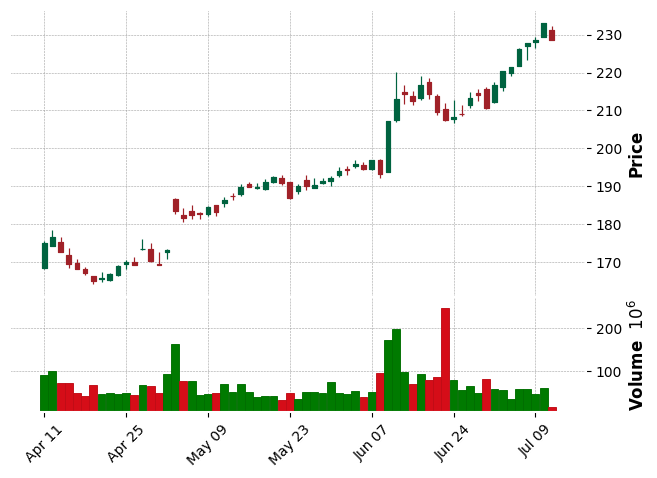

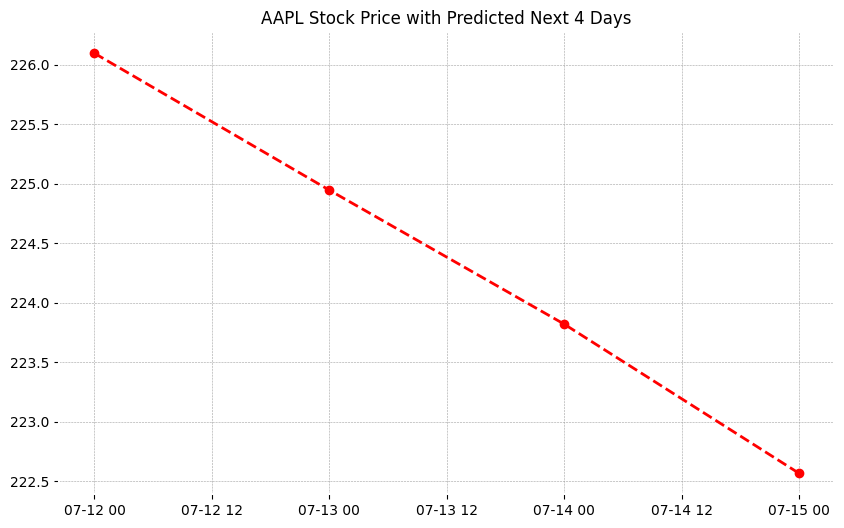

In [ ]:
# Create a list of dates for the predictions
last_date = data.index[-1]  # Get the last date from the data
next_day = last_date + pd.Timedelta(days=1)  # Calculate the next day for prediction
prediction_dates = pd.date_range(start=next_day, periods=4)  # Create 4 prediction dates

# Create a DataFrame for predicted prices with dates as index and predicted prices
predictions_df = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Plot the actual data with mplfinance
# Use candlestick chart style 'charles' with volume bars
mpf.plot(data, type='candle', style='charles', volume=True)

# Plot the predicted prices as a dashed line with markers
plt.figure(figsize=(10, 6))
plt.plot(predictions_df.index, predictions_df['Close'], linestyle='dashed', marker='o', color='red')

plt.title("AAPL Stock Price with Predicted Next 4 Days")
plt.show()

[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 40ms/step


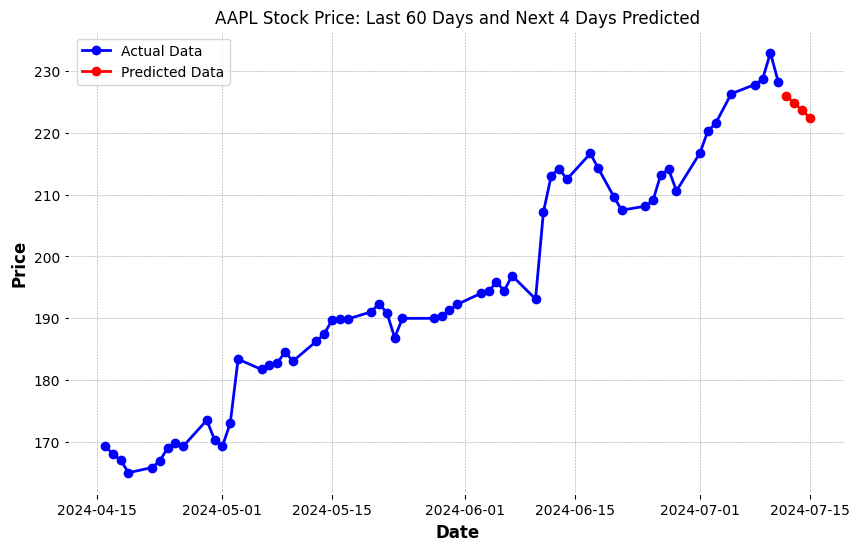

In [ ]:
data = yf.download('AAPL', period='3mo', interval='1d')

# Select 'Close' prices and scale them to range [0, 1]
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 4 days iteratively using the model
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days for prediction

for i in range(4):  # Predicting 4 days
    next_prediction = model.predict(current_batch)
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

# Create a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Create a DataFrame for predicted prices with dates as index and predicted prices
predicted_data = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Combine both actual and predicted data for plotting
combined_data = pd.concat([data['Close'][-60:], predicted_data['Close']])

# Plotting the actual data and predictions
plt.figure(figsize=(10, 6))

# Plot actual data for the last 60 days
plt.plot(data.index[-60:], data['Close'][-60:], linestyle='-', marker='o', color='blue', label='Actual Data')

# Plot predicted data for the next 4 days
plt.plot(prediction_dates, predicted_prices, linestyle='-', marker='o', color='red', label='Predicted Data')

plt.title("AAPL Stock Price: Last 60 Days and Next 4 Days Predicted")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from datetime import datetime, timedelta

def predict_stock_price(input_date):
# Predicts the stock price of AAPL for the next 4 days starting from the given input date.

    # Check if the input date is a valid date format
    try:
        input_date = pd.to_datetime(input_date)
    except ValueError:
        print("Invalid Date Format. Please enter date in YYYY-MM-DD format.")
        return

    # Fetch data from yfinance
    end_date = input_date
    start_date = input_date - timedelta(days=90)  # Fetch more days to ensure we have 60 trading days
    data = yf.download('AAPL', start=start_date, end=end_date)

    # Check if enough historical data is available
    if len(data) < 60:
        print("Not enough historical data to make a prediction. Try an earlier date.")
        return

    # Prepare the data
    closing_prices = data['Close'].values[-60:]  # Last 60 days
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(closing_prices.reshape(-1, 1))

    # Make predictions
    predicted_prices = []
    current_batch = scaled_data.reshape(1, 60, 1)

    for i in range(4):  # Predicting 4 days
        next_prediction = model.predict(current_batch)
        next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
        current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
        predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

    # Output the predictions
    for i, price in enumerate(predicted_prices, 1):
        print(f"Day {i} prediction: {price}")

# Example use
user_input = input("Enter a date (YYYY-MM-DD) to predict AAPL stock for the next 4 days: ")
predict_stock_price(user_input)

Enter a date (YYYY-MM-DD) to predict AAPL stock for the next 4 days: 2024-04-06


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step
Day 1 prediction: 171.88963317871094
Day 2 prediction: 172.3191680908203
Day 3 prediction: 173.24720764160156
Day 4 prediction: 174.44613647460938
